Классификатор для кошек/собак

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, preprocessing, regularizers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Загружаем датасет котов и собак
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
data_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)

68606236/68606236 [==============================] - 0s 0us/step


In [ ]:
# Делаем предобработку
import os, shutil

# предобрпботка исходных данных датасета
data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered')

old_train = os.path.join(data_dir, 'train')
old_validation = os.path.join(data_dir, 'validation')

os.makedirs('dataset/cats', exist_ok=True)
os.makedirs('dataset/dogs', exist_ok=True)

for c in os.listdir(os.path.join(old_train, 'cats')):
  shutil.copyfile(os.path.join(old_train, 'cats', c), os.path.join('dataset/cats', c))
for c in os.listdir(os.path.join(old_validation, 'cats')):
  shutil.copyfile(os.path.join(old_validation, 'cats', c), os.path.join('dataset/cats', c))

for c in os.listdir(os.path.join(old_train, 'dogs')):
  shutil.copyfile(os.path.join(old_train, 'dogs', c), os.path.join('dataset/dogs', c))
for c in os.listdir(os.path.join(old_validation, 'dogs')):
  shutil.copyfile(os.path.join(old_validation, 'dogs', c), os.path.join('dataset/dogs', c))


# Размер картинки и размер батча
img_size = (224, 224)
batch_size = 32

# Разбиваем выборку
train_dataset = preprocessing.image_dataset_from_directory(
    'dataset',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = preprocessing.image_dataset_from_directory(
    'dataset',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
pretrained_model.trainable = False

In [ ]:
model = models.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# компилируем модель
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy']
  )


In [ ]:

def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    if epoch <= 15:
        return 0.0001
    return 0.00001

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)


history =  model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=50,
  callbacks=[early_stopping, lr_callback],
)

Epoch 1/50
75/75 [==============================] - 16s 85ms/step - loss: 1.0753 - accuracy: 0.6179 - val_loss: 0.9160 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 6s 83ms/step - loss: 0.8557 - accuracy: 0.6875 - val_loss: 0.7946 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 5s 61ms/step - loss: 0.7664 - accuracy: 0.7175 - val_loss: 0.8045 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 5s 64ms/step - loss: 0.7080 - accuracy: 0.7554 - val_loss: 0.7382 - val_accuracy: 0.7233 - lr: 1.0000e-04
Epoch 5/50
75/75 [==============================] - 6s 68ms/step - loss: 0.6999 - accuracy: 0.7533 - val_loss: 0.7328 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 6/50
75/75 [==============================] - 5s 62ms/step - loss: 0.6862 - accuracy: 0.7596 - val_loss: 0.7288 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 7/50
75/75 [==============================] - 6s 78ms/ste

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


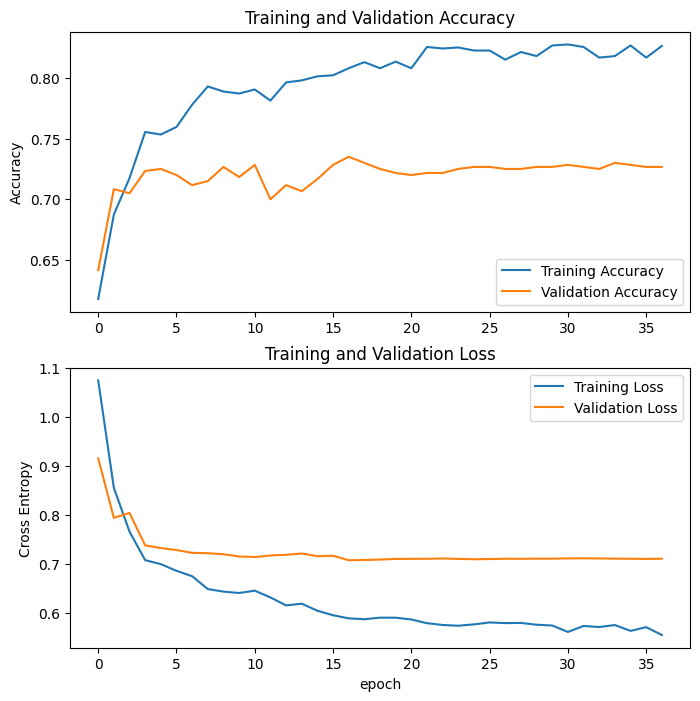

In [ ]:
print(history.history.keys())
# проверяем модель и строим графики
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()